In [212]:
import pandas as pd

df = pd.read_csv('../datasets/insurance_train.csv')
df_test =  pd.read_csv('../datasets/insurance_test.csv')

In [213]:
print(df.shape)
print(df.size)
print(df.head())
print(df.info())

(338, 7)
2366
   age     sex     bmi  children smoker     region      charges
0   26    male  27.060         0    yes  southeast  17043.34140
1   58    male  36.955         2    yes  northwest  47496.49445
2   20  female  24.420         0    yes  southeast  26125.67477
3   51  female  38.060         0    yes  southeast  44400.40640
4   62  female  25.000         0     no  southwest  13451.12200
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       338 non-null    int64  
 1   sex       338 non-null    object 
 2   bmi       338 non-null    float64
 3   children  338 non-null    int64  
 4   smoker    338 non-null    object 
 5   region    338 non-null    object 
 6   charges   338 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 18.6+ KB
None


In [214]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [216]:
df_cp = df.copy()
count = 0
for col in ["age", "bmi", "children", "charges"]:
    Q1 = df_cp[col].quantile(0.25)
    Q3 = df_cp[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    count += ((df_cp[col] < lower_bound) | (df_cp[col] > upper_bound)).sum()
    df_cp = df_cp[(df_cp[col] >= lower_bound) & (df_cp[col] <= upper_bound)]
    
print(f'всего выбросов: {count}')

df = df_cp


всего выбросов: 23


In [217]:
df['sex'] = df['sex'].map({'male': 1, 'female':0})
df['smoker'] = df['smoker'].map({'no':0, 'yes':1})

df = pd.get_dummies(df, columns=['region'], dtype=int)

df_test['sex'] = df_test['sex'].map({'male': 1, 'female':0})
df_test['smoker'] = df_test['smoker'].map({'no':0, 'yes':1})

df_test = pd.get_dummies(df_test, columns=['region'], dtype=int)

print(df.head())


   age  sex    bmi  children  smoker      charges  region_northeast  \
0   26    1  27.06         0       1  17043.34140                 0   
2   20    0  24.42         0       1  26125.67477                 0   
4   62    0  25.00         0       0  13451.12200                 0   
5   34    1  32.80         1       0  14358.36437                 0   
6   18    1  33.77         1       0   1725.55230                 0   

   region_northwest  region_southeast  region_southwest  
0                 0                 1                 0  
2                 0                 1                 0  
4                 0                 0                 1  
5                 0                 0                 1  
6                 0                 1                 0  


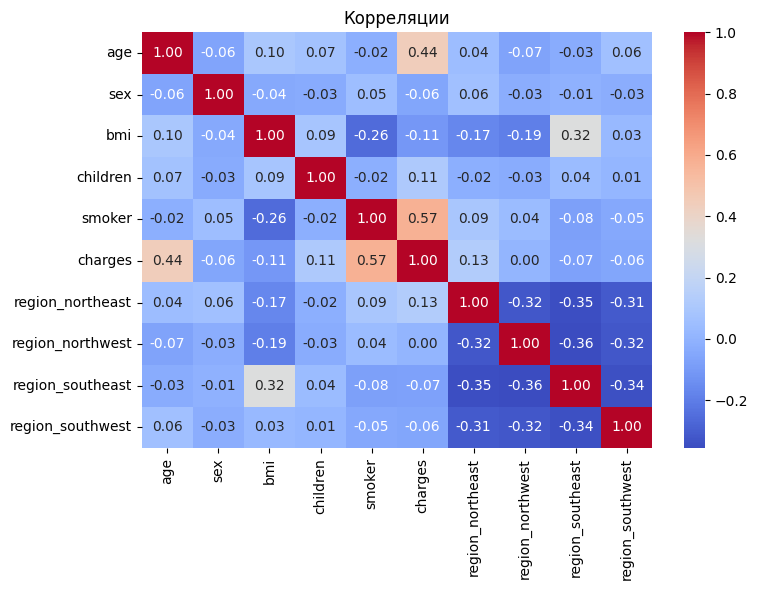

In [218]:

plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляции")
plt.tight_layout()
plt.show()

In [219]:
df = df.drop('region_southwest', axis=1)
df_test = df_test.drop('region_southwest', axis=1)

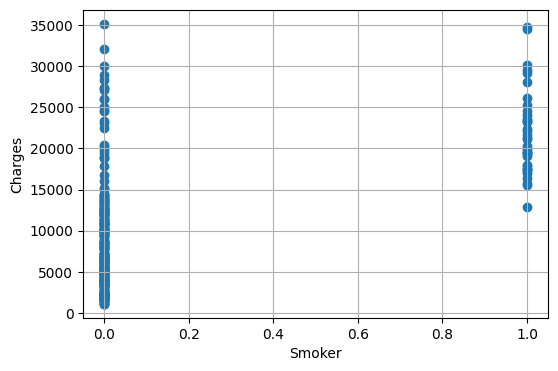

In [220]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(df['smoker'], df['charges'])
plt.xlabel('Smoker')
plt.ylabel('Charges')
plt.grid(True)
plt.show()


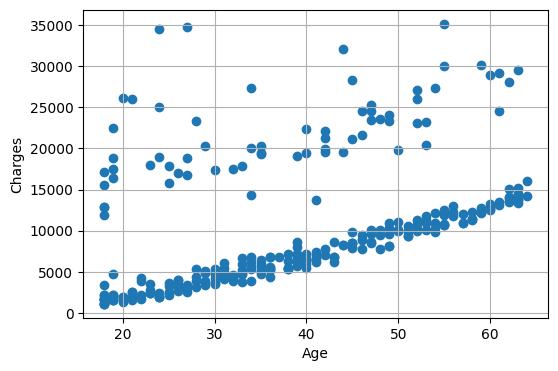

In [221]:
plt.figure(figsize=(6,4))
plt.scatter(df['age'], df['charges'])
plt.xlabel('Age')
plt.ylabel('Charges')
plt.grid(True)
plt.show()


## 2. Многомерная линейная регрессия

Модель регрессии
$$
f(x, w) = \sum_{i=1}^{n} w_i x_i = Xw
$$


$$
Q(w) = \sum_{i=1}^{\ell} (f(x_i, w) - y_i)^2 = ||Xw - y||^2 \rightarrow \min_{w} 
$$

$$
w^* = (X^TX)^{-1}X^Ty
$$

In [222]:
X_train = df.drop('charges', axis=1).values.astype(np.float64)
y_train = df['charges'].values.astype(np.float64)
feature_names = df.drop('charges', axis=1).columns.tolist()

X_train = np.column_stack([np.ones(len(X_train)), X_train])
feature_names = ['bias'] + feature_names

X_test = df_test.drop('charges', axis=1).values.astype(np.float64)
y_test = df_test['charges'].values.astype(np.float64)
X_test = np.column_stack([np.ones(len(X_test)), X_test])


In [223]:
import numpy as np

w_analytic_lin = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

for col, coef in zip(feature_names, w_analytic_lin.flatten()):
    print(f"{col}: {coef:.2f}")

bias: -2173.41
age: 248.50
sex: -898.61
bmi: 6.12
children: 589.70
smoker: 13296.61
region_northeast: 1636.82
region_northwest: 999.44
region_southeast: 535.16


Градиент функционала потерь
$$
\frac{\partial Q}{\partial w} = 2X^T(Xw-y)
$$


In [224]:
w_grad_lin = np.ones((9,))
eps = 1e-6
learning_rate = 1e-7

for i in range(2_000_000):  
    if i % 100000 == 0:
        y = X_train @ w_grad_lin
        loss = np.mean((y - y_train)**2)
        grad_norm = np.linalg.norm(gradQ)
        print(f'итерация {i}: функция потери = {loss:.2f}, норма градиента = {grad_norm:.2e}')
        
    gradQ = 2 * X_train.T @ (X_train @ w_grad_lin - y_train)
    w_grad_lin -= learning_rate * gradQ
    
    if np.linalg.norm(gradQ) < eps:
        print(f'прервались на итерации {i}')
        break

for col, coef in zip(feature_names, w_grad_lin.flatten()):
    print(f"{col}: {coef:.2f}")


итерация 0: функция потери = 164855905.53, норма градиента = 1.00e-06
итерация 100000: функция потери = 31765996.53, норма градиента = 4.47e+05
итерация 200000: функция потери = 28040779.58, норма градиента = 2.28e+05
итерация 300000: функция потери = 27044864.70, норма градиента = 1.20e+05
итерация 400000: функция потери = 26757122.87, норма градиента = 6.71e+04
итерация 500000: функция потери = 26660623.04, норма градиента = 4.14e+04
итерация 600000: функция потери = 26619301.45, норма градиента = 2.93e+04
итерация 700000: функция потери = 26596229.64, норма градиента = 2.32e+04
итерация 800000: функция потери = 26580744.82, норма градиента = 1.96e+04
итерация 900000: функция потери = 26569352.79, норма градиента = 1.70e+04
итерация 1000000: функция потери = 26560637.71, норма градиента = 1.50e+04
итерация 1100000: функция потери = 26553862.17, норма градиента = 1.32e+04
итерация 1200000: функция потери = 26548558.02, норма градиента = 1.17e+04
итерация 1300000: функция потери = 2654



**Гребневая регрессия**
$$
Q_{L_2}(w) = ||Xw - y||^2 + \alpha ||w||_2^2 \rightarrow \min_{w}
$$

$$
||a||_2 = \sqrt{\sum_{i=1}^{n} a_i^2}
$$

Имеет аналитическое решение
$$
w^* = (X^TX + \alpha I)^{-1}X^Ty
$$
где $I$ - единичная матрица

Градиент
$$
\frac{\partial Q_{L_2}}{\partial w} = 2 X^T (Xw - y) + 2 \alpha w
$$

аналитически

In [225]:
import numpy as np

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
I = np.eye(9)

w_analytic_reg = np.ones((9,))
best_mse = float('inf')
for alpha in alphas:
    w = np.linalg.inv(X_train.T @ X_train + alpha * I) @ X_train.T @ y_train

    predictions = X_test @ w
    test_mse = np.mean((predictions - y_test)**2)
    if test_mse < best_mse:
        best_mse = test_mse
        w_analytic_reg = w
    
    print(f"{alpha:5} | {test_mse:8.2f}")

print()
for col, coef in zip(feature_names, w_analytic_reg.flatten()):
    print(f"{col}: {coef:.2f}")
    

0.001 | 58802360.21
 0.01 | 58820400.10
  0.1 | 58999865.17
    1 | 60710527.93
   10 | 73400183.86
  100 | 112243083.75
 1000 | 132451882.61

bias: -2172.79
age: 248.50
sex: -898.60
bmi: 6.10
children: 589.69
smoker: 13296.14
region_northeast: 1636.72
region_northwest: 999.34
region_southeast: 535.10


In [226]:
import numpy as np

eps = 1e-6
learning_rate = 1e-7
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

best_test_mse = float('inf')
w_grad_reg = None


for alpha in alphas:
    w_current = np.ones((9,))
    
    for i in range(2_000_000):  
        gradQ = 2 * X_train.T @ (X_train @ w_current - y_train) + 2 * alpha * w_current
        w_current -= learning_rate * gradQ
        
        if np.linalg.norm(gradQ) < eps:
            break
    

    test_pred = X_test @ w_current
    test_mse = np.mean((test_pred - y_test)**2)
    
    print(f"{alpha:6} | {test_mse:8.2f}")

    if test_mse < best_test_mse:
        best_test_mse = test_mse
        w_grad_reg = w_current.copy()

print()

for col, coef in zip(feature_names, w_grad_reg.flatten()):
    print(f"{col}: {coef:.2f}")

 0.001 | 59155376.17
  0.01 | 59171756.45
   0.1 | 59335072.20
     1 | 60921296.97
    10 | 73403124.06
   100 | 112243083.75
  1000 | 132451882.61

bias: -1811.19
age: 247.15
sex: -918.22
bmi: -2.13
children: 587.06
smoker: 13251.52
region_northeast: 1574.60
region_northwest: 928.44
region_southeast: 506.89


In [227]:
constant_pred = np.mean(y_train) * np.ones(len(y_test))
mse_constant = np.mean((constant_pred - y_test)**2)

pred_analytic_lin = X_test @ w_analytic_lin
mse_analytic_lin = np.mean((pred_analytic_lin - y_test)**2)

pred_grad_lin = X_test @ w_grad_lin
mse_grad_lin = np.mean((pred_grad_lin - y_test)**2)

pred_analytic_reg = X_test @ w_analytic_reg
mse_analytic_reg = np.mean((pred_analytic_reg - y_test)**2)

pred_grad_reg = X_test @ w_grad_reg
mse_grad_reg = np.mean((pred_grad_reg - y_test)**2)

print(f"Константная модель:      {mse_constant:.2f}")
print(f"Линейная (аналитич.):    {mse_analytic_lin:.2f}")
print(f"Линейная (градиентн.):   {mse_grad_lin:.2f}")
print(f"Регуляризационная (аналитич.):        {mse_analytic_reg:.2f}")
print(f"Регуляризационная (градиентн.):       {mse_grad_reg:.2f}")

Константная модель:      147542797.92
Линейная (аналитич.):    58800354.72
Линейная (градиентн.):   59153555.59
Регуляризационная (аналитич.):        58802360.21
Регуляризационная (градиентн.):       59155376.17
